## Задача

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

Нужно постоить модель, которая предскажет температуру стали.

## Описание данных 

Описание данных
Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
!pip install missingno
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import missingno as msno
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

RS = 30723
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = 'C:/data/progect_metal/' if os.path.exists('C:/data/progect_metal/') else '/datasets/'

arc = pd.read_csv(path + 'data_arc_new.csv')
bulk = pd.read_csv(path + 'data_bulk_new.csv')
bulk_time = pd.read_csv(path + 'data_bulk_time_new.csv')
gas = pd.read_csv(path + 'data_gas_new.csv')
temp = pd.read_csv(path + 'data_temp_new.csv')
wire = pd.read_csv(path + 'data_wire_new.csv')
wire_time = pd.read_csv(path + 'data_wire_time_new.csv')

### Анализ данных

#### Посмотрим на данные об электродах 

In [4]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков нет

In [5]:
arc['key'].nunique()

3214

Всего 3214 партии

In [6]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [7]:
arc.sort_values('Реактивная мощность')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525
...,...,...,...,...,...
8963,1944,2019-07-20 14:55:25,2019-07-20 14:59:27,1.399275,1.214912
14115,3069,2019-08-31 20:02:33,2019-08-31 20:04:24,1.339945,1.222632
8116,1759,2019-07-07 22:52:07,2019-07-07 22:56:35,1.381885,1.223063
3452,748,2019-06-01 16:24:02,2019-06-01 16:26:16,1.374768,1.258628


Одно отрицательное значение в колонке `Реактивная мощность`

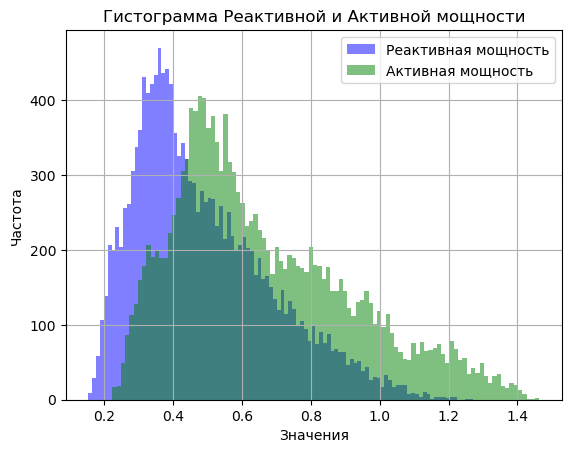

In [8]:
arc[arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, color='blue', alpha=0.5, label='Реактивная мощность');
arc[arc['Реактивная мощность'] > 0]['Активная мощность'].hist(bins=100, color='green', alpha=0.5, label='Активная мощность');

plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма Реактивной и Активной мощности')
plt.legend()

plt.show()

Выбросов помимо одного отрицательного значения нет

#### Рассмотрим данные о подаче сыпучих материалов (объём и время)

In [9]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Много пропусков, в некоторых столбцах пропущены почти все значения

In [11]:
bulk['key'].nunique()

3129

В этой таблице партий меньше чем в таблице `arc`
каждой партии соответствует одна строчка 

In [12]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Предположу что не во все партии добавлялись те или иные сыпучие материалы, значит пропуски можно заменить на 0

Большенство присадок добавляли не во все партии

Рассмотрим присадки которые добавили хотя бы в половину партий 

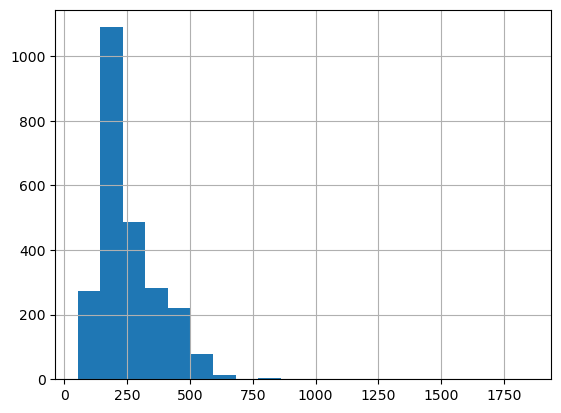

In [13]:
bulk['Bulk 12'].hist(bins=20);

Есть выброс в большую сторону

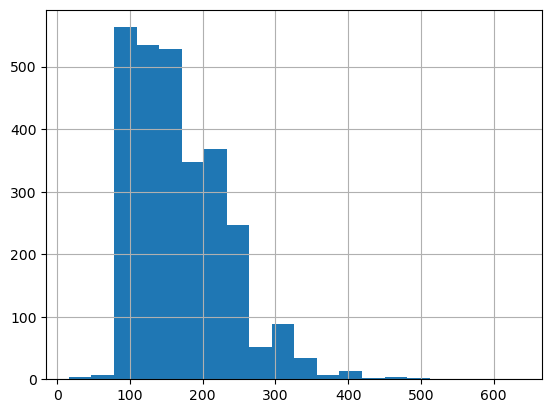

In [14]:
bulk['Bulk 14'].hist(bins=20);

сильных выбросов нет, в некоторые партии добавляли больше этой добавки

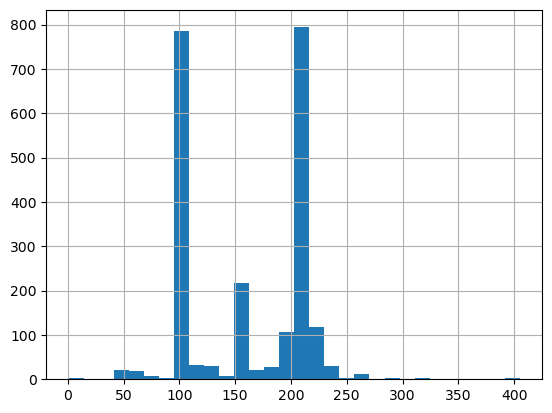

In [15]:
bulk['Bulk 15'].hist(bins=30);

Два явных пика, в большенство партий, из тез в которые добавляют эту присадку, объемами около 100, 150 или 210, возможно для разных типов стали требуется разный обем этой присадки

#### Рассмотрим таблицы с данными о проволочных материалах, объем и время

In [16]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [17]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [18]:
wire['key'].nunique()

3081

Данные схожи с данными о сыпучих материалах, много пропусков, каждая строчка соответствует одной партии

In [19]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Так же как и с сыпучеми материалами, пропуски можно заменить на 0

`Wire 1` добаляют почти во все партии `Wire 2` только в треть, остальные добавляли в небольшое количество партий\
посмотрим на распределения `Wire 1` и `Wire 2`

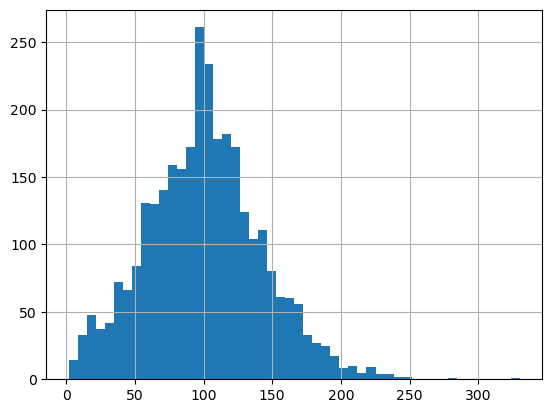

In [20]:
wire['Wire 1'].hist(bins=50);

в большенство партий добавляют около 100 единиц этой присадки

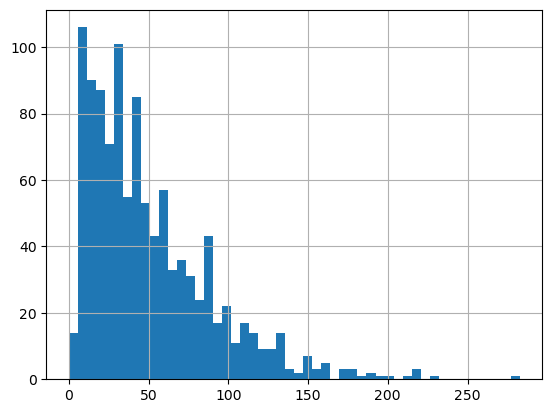

In [21]:
wire['Wire 2'].hist(bins=50);

В большенство партий, из тех в которые добавляется эта присадка, добавляется не больше 50 единиц

#### Данные о продувке сплава газом

In [22]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет

In [23]:
gas['key'].nunique()

3239

Каждая сточка соответствует одной партии

In [24]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


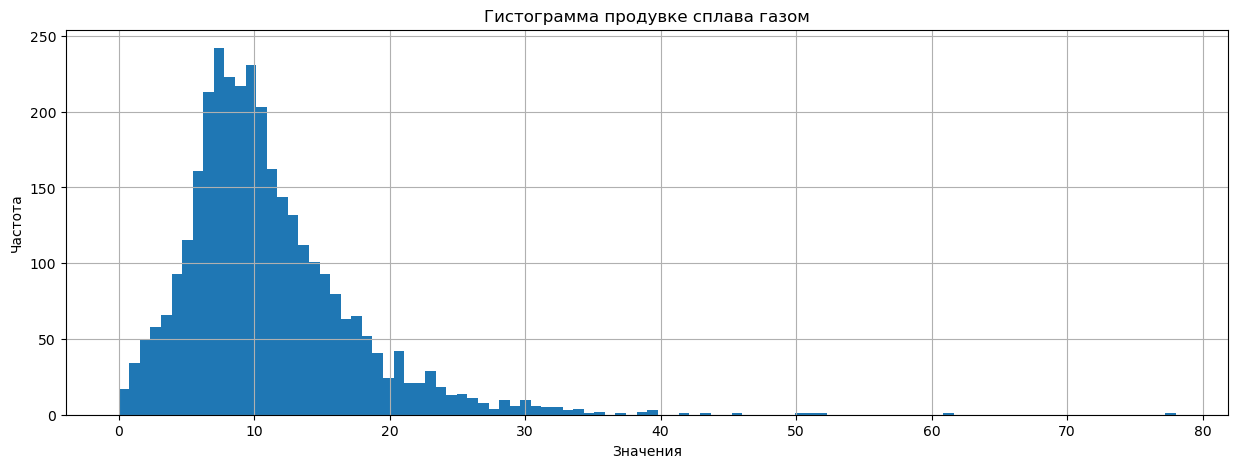

In [25]:
plt.figure(figsize=(15, 5))
gas['Газ 1'].hist(bins=100);

plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма продувке сплава газом')

plt.show()

Присутствует небольшое количество выбросов

#### Данные о результатах измерения температуры

In [26]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [27]:
temp['key'].nunique()

3216

В данных температуры присутствуют пропуски

In [28]:
temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


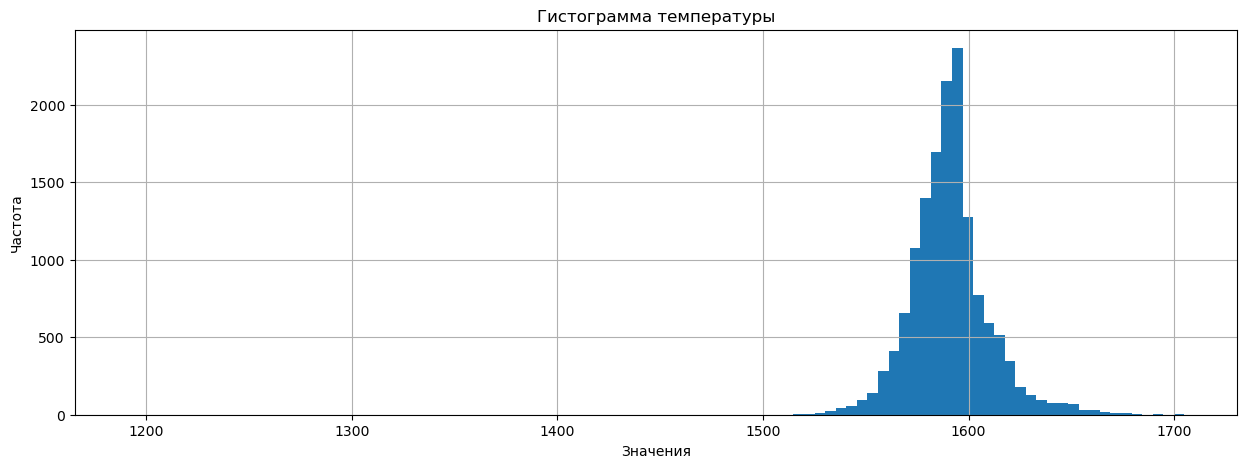

In [29]:
plt.figure(figsize=(15, 5))
temp['Температура'].hist(bins=100);

plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма температуры')

plt.show()

Распределение близкое к нормальному, есть немного выбросов

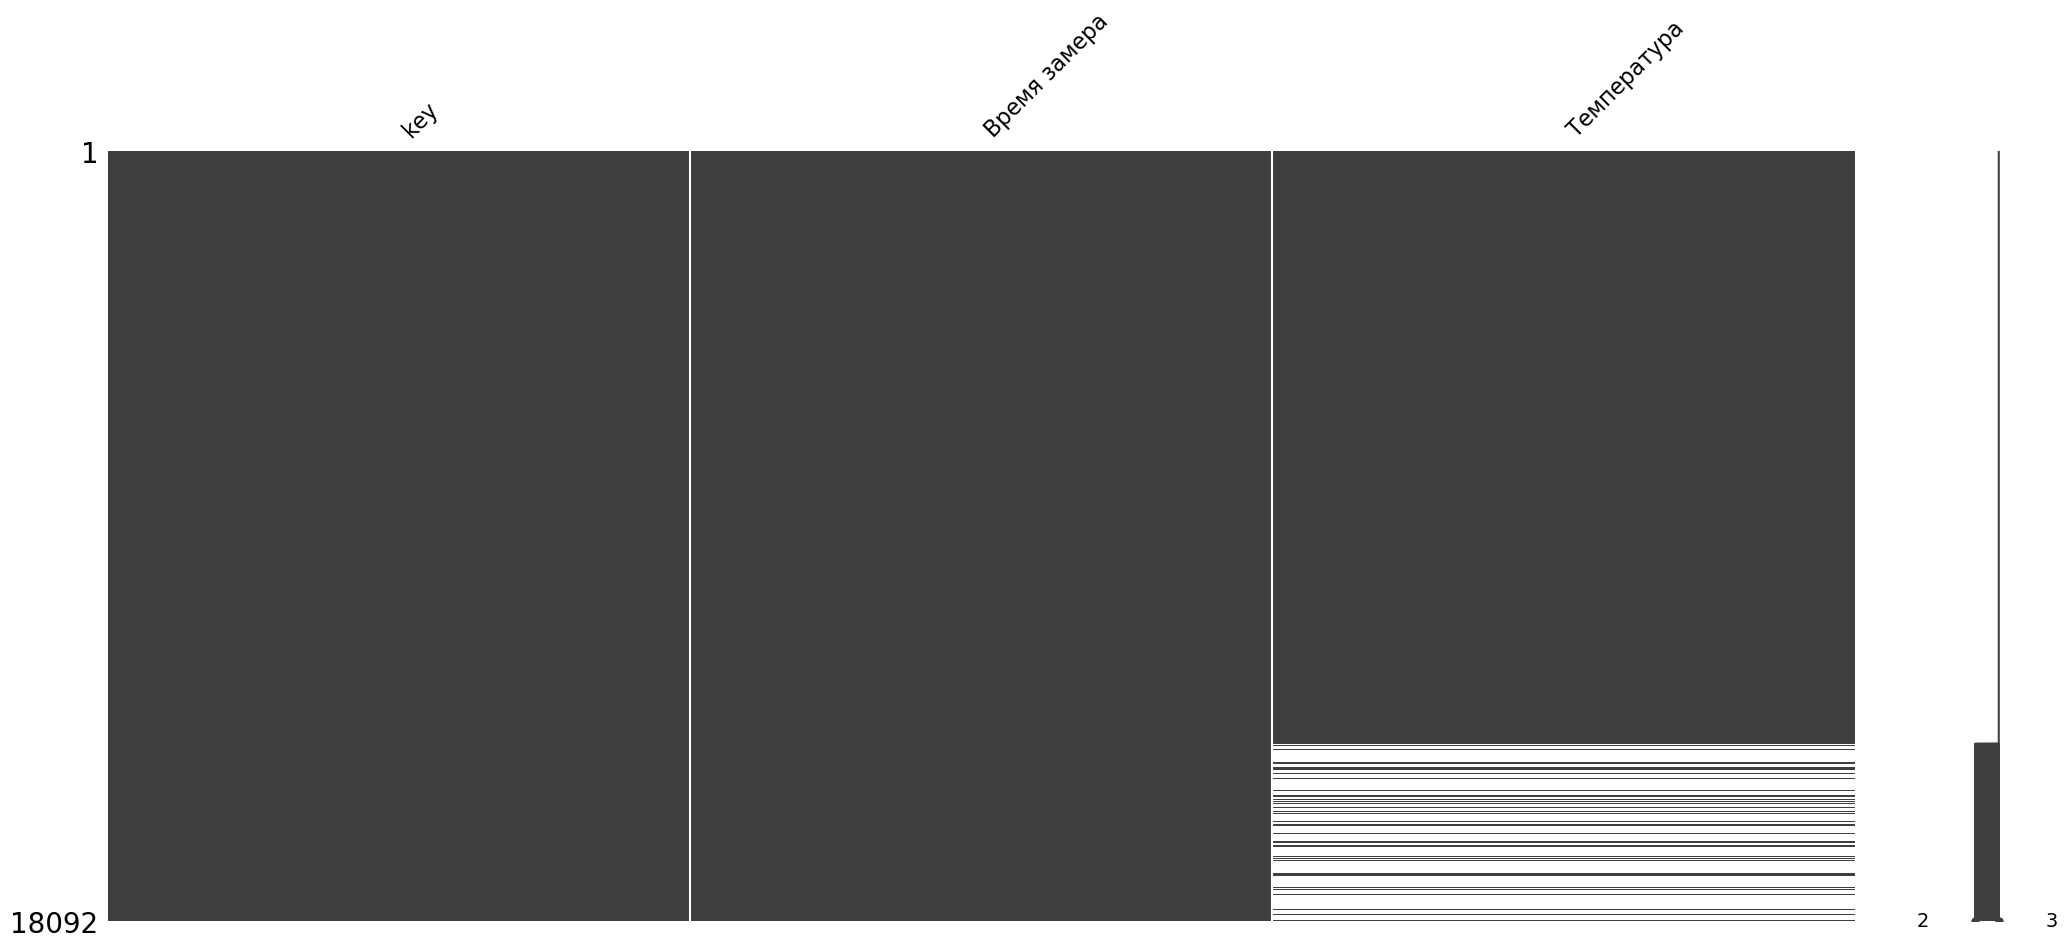

In [30]:
msno.matrix(temp);

Все пропуски в конце датасета

In [31]:
temp.iloc[13920:13940]

,key,Время замера,Температура
13920,2498,2019-08-10 13:23:31,1594.0
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0
13925,2499,2019-08-10 13:58:58,1603.0
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN


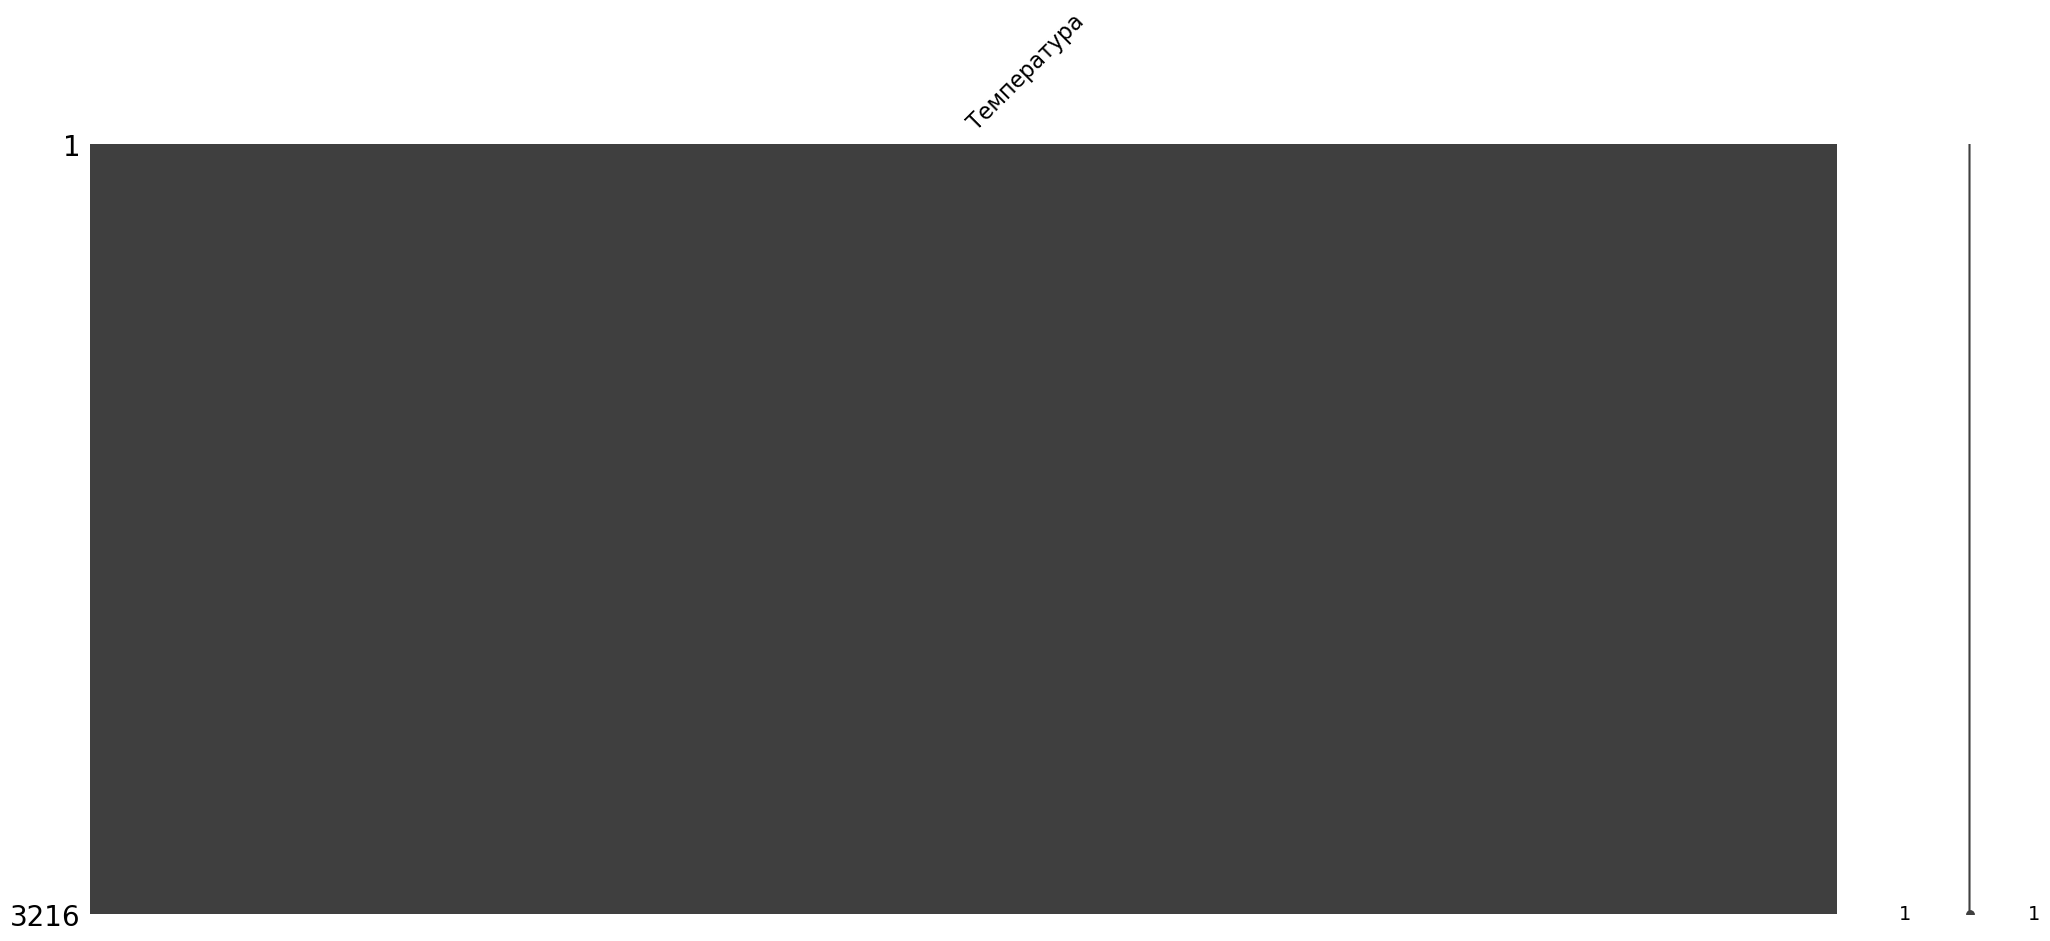

In [32]:
msno.matrix(temp.groupby('key').mean());

Начиная с 2500 партии температура замерялась по 1 разу для каждой партии

In [33]:
print(arc['key'].nunique(), 'партий на этапе нагрева электродами')
print(bulk['key'].nunique(), 'партий на этапе добавления сыпучих материалов')
print(wire['key'].nunique(), 'партий на этапе добавления проволочных материалов')
print(gas['key'].nunique(), 'партий на этапе продувки газом')
print(temp['key'].nunique(), 'партий с замереной температурой')

3214 партий на этапе нагрева электродами
3129 партий на этапе добавления сыпучих материалов
3081 партий на этапе добавления проволочных материалов
3239 партий на этапе продувки газом
3216 партий с замереной температурой


### Вывод

- В данных об электродах присутствует одно аномальное значение 
- В данных о добавлении сыпучих и проволочных материалов много пропусков
- Распределение значений о продувке газом близкое к нормальному, имеется небольшое колличество выбросов
- Распределение значений о темпиратуре близкое к нормальному, начиная с 2500 партии теппиратура замерялась по 1 разу для каждой партии
- На разных этапах разное количество партий

### План действий

- Заполнить пропуски там где это возможно
- объединить данные в один датасет
- разбить на выборки и обучить несколько моделей

## Предобработка данных

### Таблица temp

Целевой признак это последняя измеренная температура в партии.
Начиная с 2500 партии есть только первая измереная температура, оставим все партии до 2500.

In [34]:
df = temp[temp['key'] < 2500].copy()

In [35]:
df['target'] = df.groupby('key')['Температура'].transform('last')

In [36]:
df

,key,Время замера,Температура,target
0,1,2019-05-03 11:02:04,1571.0,1613.0
1,1,2019-05-03 11:07:18,1604.0,1613.0
2,1,2019-05-03 11:11:34,1618.0,1613.0
3,1,2019-05-03 11:18:04,1601.0,1613.0
4,1,2019-05-03 11:25:59,1606.0,1613.0
...,...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0,1603.0
13922,2499,2019-08-10 13:41:34,1604.0,1603.0
13923,2499,2019-08-10 13:46:28,1593.0,1603.0
13924,2499,2019-08-10 13:54:56,1588.0,1603.0


Удалим строки с температурой равной целевой

In [37]:
#df = df[df['Температура'] != df['target']]
df[df.groupby('key')['key'].transform('count') == 1]

,key,Время замера,Температура,target
1105,195,2019-05-11 00:01:36,1583.0,1583.0
1549,279,2019-05-14 10:13:01,1603.0,1603.0


In [38]:
df = df[df.groupby('key')['key'].transform('count') != 1]

In [39]:
df

,key,Время замера,Температура,target
0,1,2019-05-03 11:02:04,1571.0,1613.0
1,1,2019-05-03 11:07:18,1604.0,1613.0
2,1,2019-05-03 11:11:34,1618.0,1613.0
3,1,2019-05-03 11:18:04,1601.0,1613.0
4,1,2019-05-03 11:25:59,1606.0,1613.0
...,...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0,1603.0
13922,2499,2019-08-10 13:41:34,1604.0,1603.0
13923,2499,2019-08-10 13:46:28,1593.0,1603.0
13924,2499,2019-08-10 13:54:56,1588.0,1603.0


Групируем итоговою таблицу 

In [40]:
df = df.groupby('key').first().reset_index()

### Таблица arc

Подготовим таблицу `arc` к присоединению к общей\
посчитаем общую мощьность и общее время нагрева партии

Оставим только записи, где Реактивная мощность > 0\
Изменим тип данных даты и времени

In [42]:
arc = arc[arc['Реактивная мощность'] > 0]

In [43]:
# Приводим данные к нужному формату
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

# создаем столбец с временем нагрева, c количеством циклов нагрева и суммарным временем нагрева
arc['time'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds()
arc['count_time'] = arc.groupby('key')['time'].transform('count')
arc['sum_time'] = arc.groupby('key')['time'].transform('sum')

# Полная мощьность
arc['power'] = (arc['Активная мощность']**2 + arc['Реактивная мощность']**2)**0.5

# Группируем таблицу 
arc = arc.groupby('key').first().reset_index()

### Таблицы с присадками

подготовим таблицы с присадками\
добавим столбец с общим количеством присадок добавленых в партию

In [44]:
# Создаем столбцы с суммой всех добавленых приадок
bulk['sum_bulk'] = bulk.iloc[:, 1:].sum(axis=1)
wire['sum_wire'] = wire.iloc[:, 1:].sum(axis=1)

# Столбцы с количеством добавленых присадок
bulk['count_bulk'] = bulk.count(axis=1) - 1
wire['count_wire'] = wire.count(axis=1) - 1

Заполним пропуски и разделим `bulk_15` на группы 

In [45]:
bulk = bulk.fillna(0)
wire = wire.fillna(0)

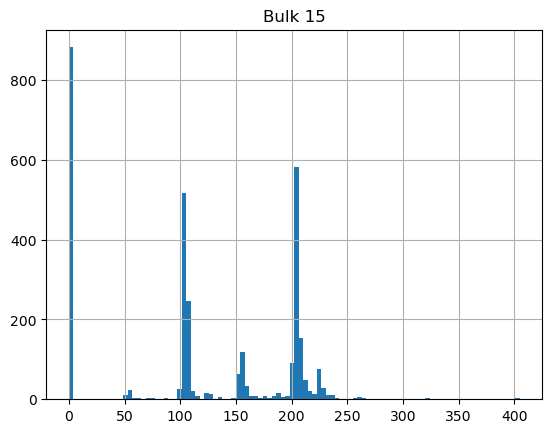

In [46]:
bulk['Bulk 15'].hist(bins=100)
plt.title('Bulk 15')
plt.show()

In [47]:
# разделение на группы
bulk['bulk_15_group'] = pd.cut(bulk['Bulk 15'],
                               bins=[-1, 25, 75, 125, 175, 250, 500],
                              labels=[0, 1, 2, 3, 4, 5])

### Соединим все таблицы

In [48]:
df = df.merge(arc, on='key')
df = df.merge(bulk, on='key')
df = df.merge(wire, on='key')
df = df.merge(gas, on='key')

In [49]:
df

,key,Время замера,Температура,target,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time,count_time,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,count_wire,Газ 1
0,1,2019-05-03 11:02:04,1571.0,1613.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,2,29.749986
1,2,2019-05-03 11:34:04,1581.0,1602.0,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,2,12.555561
2,3,2019-05-03 12:06:44,1596.0,1599.0,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,2,28.554793
3,4,2019-05-03 12:39:27,1601.0,1625.0,2019-05-03 12:39:37,2019-05-03 12:43:04,0.642946,0.516071,207.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,2,18.841219
4,5,2019-05-03 13:11:03,1576.0,1602.0,2019-05-03 13:11:13,2019-05-03 13:15:24,0.324563,0.279102,251.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,3,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,2019-08-10 11:27:47,1570.0,1591.0,2019-08-10 11:27:57,2019-08-10 11:31:24,0.430979,0.359487,207.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,2,7.125735
2325,2496,2019-08-10 11:56:48,1554.0,1591.0,2019-08-10 11:56:58,2019-08-10 11:58:55,0.333029,0.228362,117.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,2,9.412616
2326,2497,2019-08-10 12:37:26,1571.0,1589.0,2019-08-10 12:37:36,2019-08-10 12:40:12,1.268378,0.859087,156.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,3,6.271699
2327,2498,2019-08-10 12:58:11,1591.0,1594.0,2019-08-10 12:58:21,2019-08-10 13:02:37,0.419017,0.295789,256.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.110717,2,14.953657


### Вывод по предобработке

В результате предобработки мы выделили целевой признак (последняя измереная температура) \
на основе имеющихся данных сделали новые признаки\
собрали все данные в одну таблицу 

## Исследование итоговой таблицы с данными

Удалим колонки с данными о времени, с показаниями активной и реактивной мощности, а также удалим те присадки, которые добавлялись в небольшое количество партий.

In [50]:
df = df.drop(columns=['Время замера',
                      'Активная мощность', 'Реактивная мощность',
                      'Начало нагрева дугой',
                      'Конец нагрева дугой',
                      'Wire 5', 'Wire 3', 'Wire 4', 'Wire 5','Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
                      'Bulk 2','Bulk 5','Bulk 7','Bulk 8','Bulk 9','Bulk 2','Bulk 13',          
                      ])

In [51]:
pd.set_option('display.max_columns', None)

In [52]:
df.describe()

,key,Температура,target,time,count_time,sum_time,power,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,sum_bulk,count_bulk,Wire 1,Wire 2,sum_wire,count_wire,Газ 1
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,1586.718763,1593.365393,157.084156,4.695148,807.600687,0.823898,3.427651,47.348218,37.303564,22.430228,5.052812,4.245170,208.415629,153.853585,119.952769,609.630313,4.592958,102.443601,17.609859,125.208530,2.397166,11.375600
std,714.762400,28.290792,11.200915,67.269862,1.606948,340.897332,0.326493,12.412132,75.310430,58.643238,55.790873,20.917800,22.515487,157.062272,81.404354,84.640443,287.599678,1.224416,43.539993,33.624771,63.683386,0.564416,6.392041
min,1.000000,1191.000000,1541.000000,23.000000,1.000000,57.000000,0.293682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,2.000000,0.000000,0.000000,1.918800,2.000000,0.008399
25%,630.000000,1571.000000,1587.000000,122.000000,4.000000,581.000000,0.579284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,440.000000,4.000000,73.207679,0.000000,89.013596,2.000000,7.282948
50%,1255.000000,1587.000000,1593.000000,136.000000,5.000000,778.000000,0.741836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,609.000000,5.000000,101.119201,0.000000,116.101440,2.000000,10.100950
75%,1868.000000,1603.000000,1598.000000,173.000000,6.000000,993.000000,1.025754,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,282.000000,204.000000,204.000000,795.000000,5.000000,128.091599,23.102560,151.568558,3.000000,14.216688
max,2499.000000,1660.000000,1653.000000,724.000000,16.000000,4189.000000,1.898158,185.000000,454.000000,281.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000,3235.000000,8.000000,330.314424,282.780152,568.777664,6.000000,77.995040


In [53]:
df

,key,Температура,target,time,count_time,sum_time,power,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,sum_bulk,count_bulk,bulk_15_group,Wire 1,Wire 2,sum_wire,count_wire,Газ 1
0,1,1571.0,1613.0,228.0,5,1098.0,0.371123,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,553.0,5,3,60.059998,0.00000,60.059998,2,29.749986
1,2,1581.0,1602.0,137.0,4,811.0,0.440239,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,582.0,5,3,96.052315,0.00000,96.052315,2,12.555561
2,3,1596.0,1599.0,280.0,5,655.0,1.373863,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,544.0,5,3,91.160157,0.00000,91.160157,2,28.554793
3,4,1601.0,1625.0,207.0,4,741.0,0.824445,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,595.0,5,3,89.063515,0.00000,89.063515,2,18.841219
4,5,1576.0,1602.0,251.0,4,869.0,0.428064,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,584.0,5,3,89.238236,9.11456,98.352796,3,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,207.0,4,723.0,0.561225,0.0,21.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,719.0,6,4,89.150879,0.00000,89.150879,2,7.125735
2325,2496,1554.0,1591.0,117.0,6,940.0,0.403804,0.0,0.0,63.0,0.0,122.0,0.0,256.0,129.0,226.0,796.0,6,4,114.179527,0.00000,114.179527,2,9.412616
2326,2497,1571.0,1589.0,156.0,3,569.0,1.531931,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0,665.0,5,4,94.086723,9.04800,103.134723,3,6.271699
2327,2498,1591.0,1594.0,256.0,5,750.0,0.512900,0.0,90.0,0.0,0.0,101.0,0.0,206.0,129.0,207.0,733.0,6,4,118.110717,0.00000,118.110717,2,14.953657


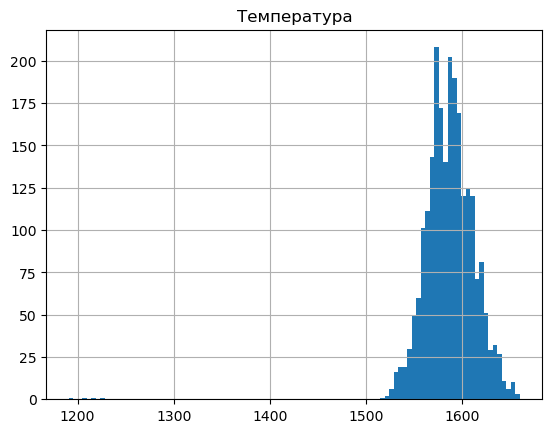

In [54]:
df['Температура'].hist(bins=100)
plt.title('Температура')
plt.show()

In [55]:
df = df[df['Температура'] > 1400]

Построим матрицу кореляции признаков 

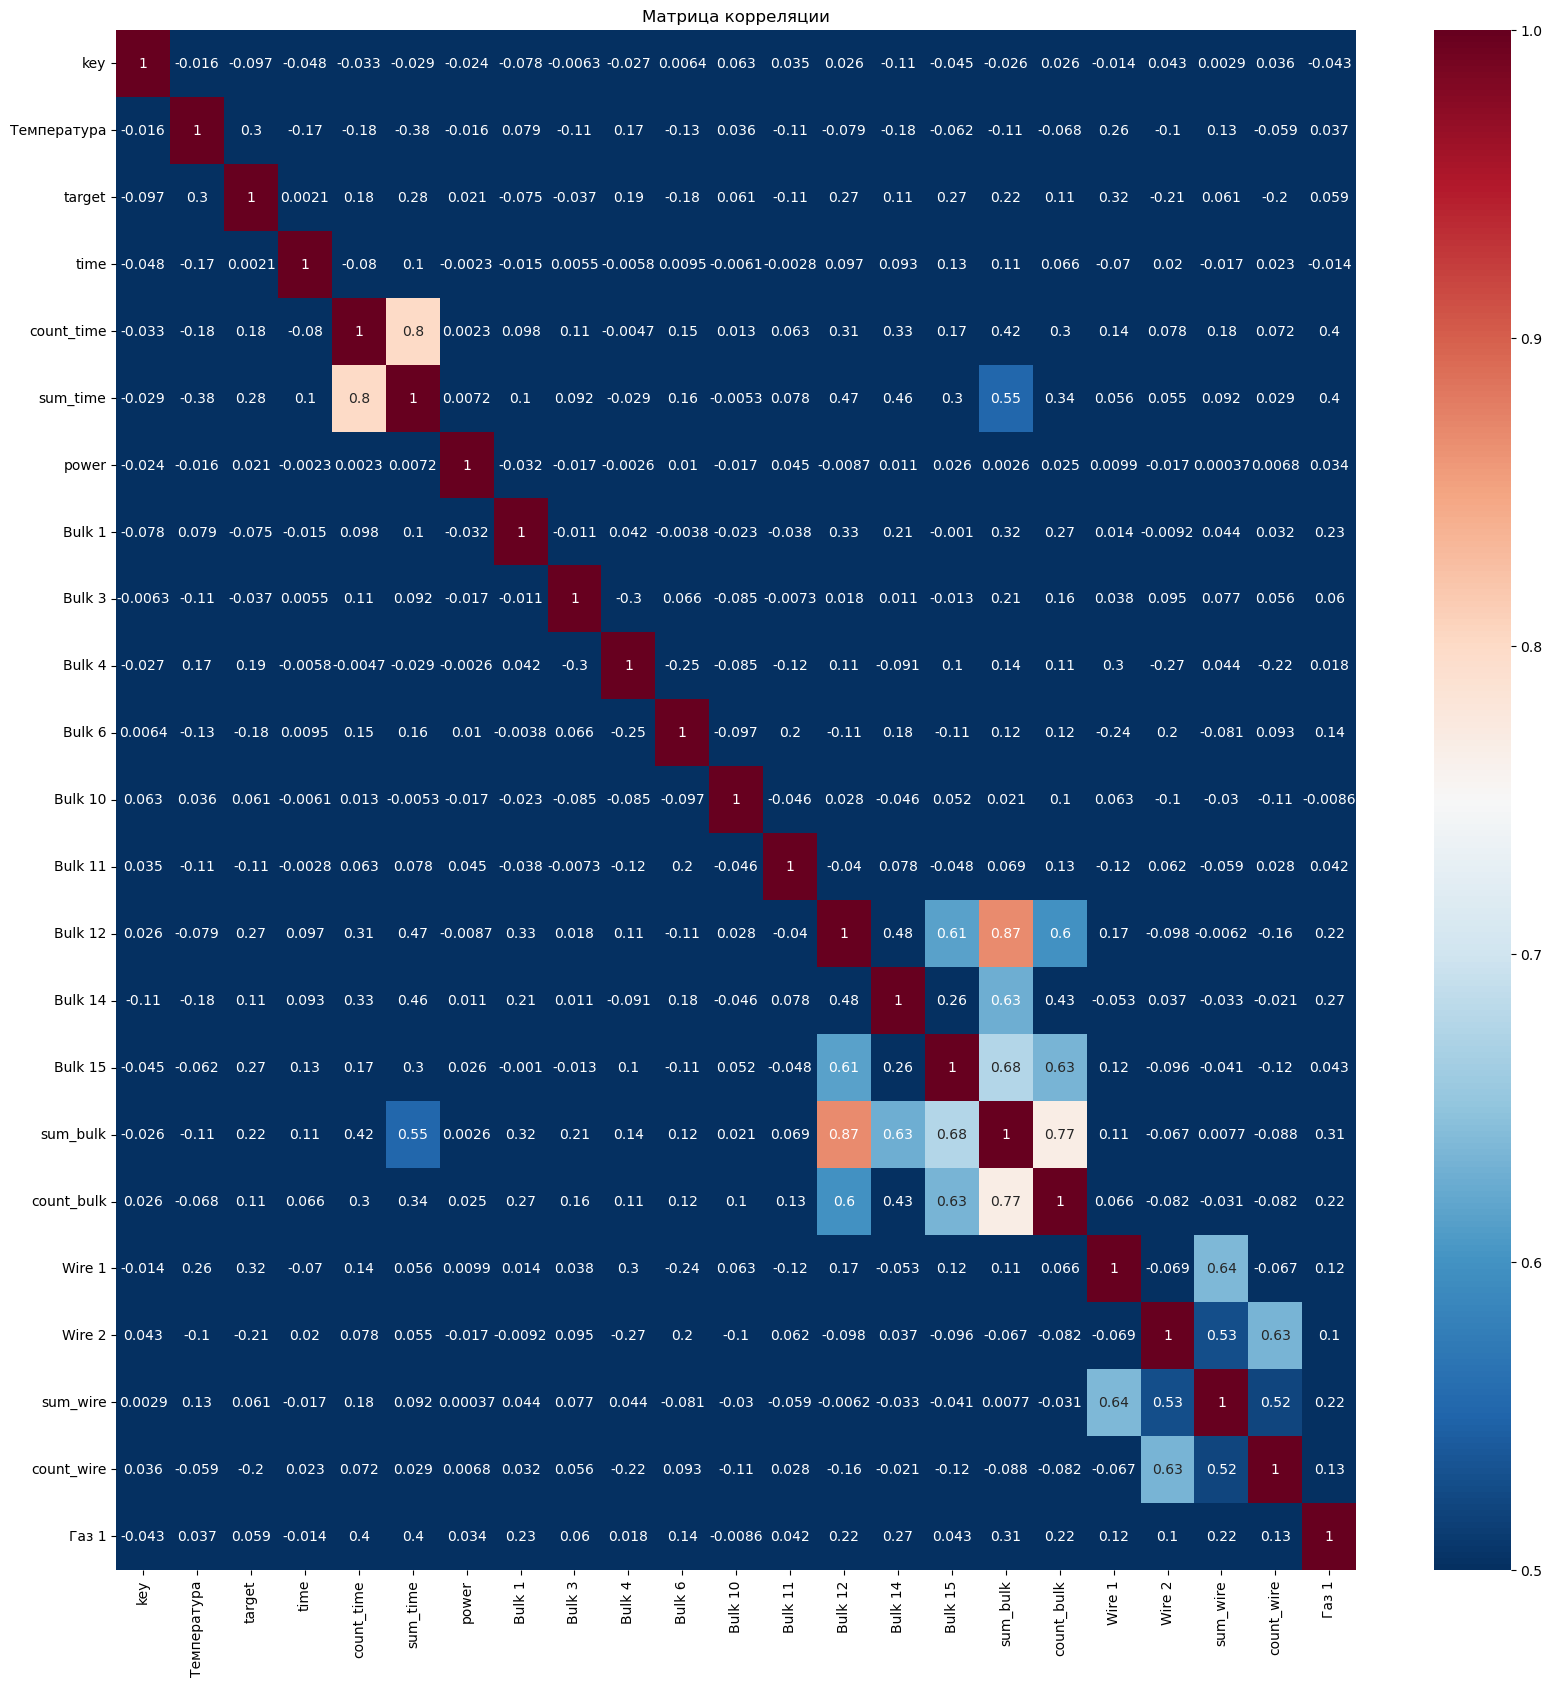

In [56]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, ax=ax, cmap='RdBu_r', vmin=0.5)
plt.title('Матрица корреляции')
plt.show()

Удалим `count_time`, `Bulk 12`

In [57]:
df = df.drop(columns=['count_time', 'Bulk 12',
                      ])

Вывод по итоговой таблице\
В итоговой таблице присутствует корреляция между созданными признаками и признаками, на основе которых они были созданы. В данном случае, поскольку созданные признаки содержат информацию об удаленных признаках, оставим их в итоговой таблице.

## Построение моделей

Раздедим данные на выборки

In [58]:
X = df.drop(columns=['target', 'key'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=RS)

### LinearRegression

In [59]:
model = LinearRegression(normalize=True)
best_lr = model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
lr_score = -scores.mean()
print("MAE: ", -scores.mean())

MAE:  6.4713125729293495


### CatBoost

In [60]:
%%time
param_grid = {
    'iterations': range(1000, 1501, 100),
    'learning_rate': [0.1, 0.3, 0.5],
    'depth': range(7, 10, 1),
    #'l2_leaf_reg': [0.1, 0.5, 1.0],
}

cat_features = ['bulk_15_group',
                'count_bulk',
                'count_wire'
               ]

cat = CatBoostRegressor(cat_features=cat_features, 
                        verbose=False,
                        loss_function='MAE',
                        random_seed=RS)



model = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=5,
    random_state=RS
)

fit_params = {
    'early_stopping_rounds': 100,
    #'plot':True
}

model.fit(X_train, y_train, **fit_params)
best_cat = model.best_estimator_


cat_score = -model.best_score_



print("MAE: ", -model.best_score_)

MAE:  6.399405730893035
Wall time: 28min 41s


### lgbm

In [61]:
%%time
param_grid = {
    'n_estimators': range(1000, 3001, 100),
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': range(5, 11, 1),
    'reg_lambda': [0.1, 0.5, 1.0],
}



lgbm = LGBMRegressor(boosting_type='goss',
                     categorical_feature=[13,14,18],
                     objective='mae',
                     random_state=RS)

model = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=10,
    random_state=RS
)

model.fit(X_train, y_train,)
best_lgbm = model.best_estimator_
lgbm_score = -model.best_score_

print("MAE: ", -model.best_score_)

MAE:  6.222644141349384
Wall time: 3min 16s


In [71]:
pd.DataFrame({'Модель': ['LGBM', 'CatBoost', 'LinearRegression'], 'Оценка': [lgbm_score, cat_score, lr_score]})

,Модель,Оценка
0,LGBM,6.222644
1,CatBoost,6.399406
2,LinearRegression,6.471313


Метрики всех моделей удовлетваряют условиям задачи, лучше всего себя показала молель градиентного бустинга LightGBM

### Тестирование лучшей модели

Лучшая всего себя показала модель lgbm, проверим её на тестовых данных

In [64]:
prediction = best_lgbm.predict(X_test)
MAE = mean_absolute_error(y_test, prediction)
print('Модель lgbm')
print(f'MAE: {MAE}')

Модель lgbm
MAE: 5.907127054258906


Постром график фажных признаков

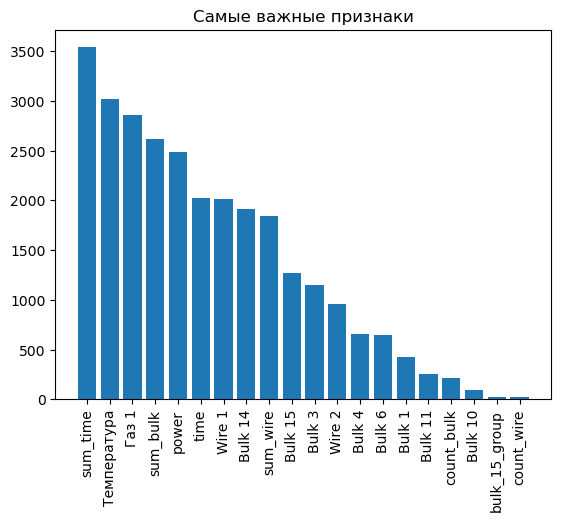

In [65]:
feature_importances = pd.DataFrame(index = X_train.columns, data = best_lgbm.feature_importances_)
top_feature = feature_importances.sort_values(by = [0], ascending=False).head(20)

plt.bar(top_feature.index , top_feature[0]);
plt.title('Самые важные признаки')
plt.xticks(rotation=90)

plt.show()

# Отчёт 

В процессе выполнения проекта были выполнены следующие пункты:
Изучены данные проекта.
Были выделены основные признаки из данных.
Построены модели на основе этих признаков.
  
Возникшие трудности и их преодоление:
Одной из трудностей было наличие небольшой выборки данных. Для преодоления этой проблемы было принято решение создать новые признаки на основе имеющихся данных.

Основные шаги выполнения задачи
- Проведение разведочного анализа данных.
- Сбор данных в единую таблицу.
- Генерацию дополнительных признаков на основе доступных данных.
- Построение модели на основе обработанных признаков.

Итог

Итоговая модель LGBM. Качество модели оценивалось с помощью метрики `MAE` (среднее абсолютное отклонение) и составило `5.9`.
Самыми значимыми признаками, использованными для обучения лучшей модели, оказались температура ковша, суммарное время нагрева и объем газа.

Гиперпараметры лучшей модели:
- learning_rate: 0.01
- max_depth: 9
- n_estimators: 1000
- random_state: 30723
- reg_alpha': 0.0
- Так же в качестве категориальных признаков были указана количество присадок (отдельно проволочных и отдельно сыпучих) а так же,  приадка `bulk 15` разбитя на 5 групп исходя из обема.

Рекомендации для улучшения модели и принятия решений:\
Для улучшения модели рекомендуется учитывать больше параметров, таких как состав сплава и содержание различных веществ в сплаве. Это может дать более полную информацию и улучшить предсказательные способности модели.